In [1]:
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
from tqdm import tqdm
#to play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional, BatchNormalization
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import os
import shutil
if os.path.exists('./prep/'):
    shutil.rmtree('./prep/')
label_csv = '../input/environmental-sound-classification-50/esc50.csv'
audio_fpath = "../input/environmental-sound-classification-50/audio/audio/44100/"

In [2]:
class AudioAugmentation:
    
    def read_audio_file(self, file_path):
        input_length = 220500
        data = librosa.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 22050)
    
    def stretch(self, data, rate=1):
        input_length = 220500
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    def write_audio_file(self, file, data, sample_rate=44100):
        librosa.output.write_wav(file, data, sample_rate)

In [3]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)
        
def wav2mel(path, clip, output, sample_rate=44100):
    x, sr = librosa.load(path+clip, sr=sample_rate)
    sgram=librosa.stft(x)
    sgram_mag, _ = librosa.magphase(sgram)
    
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.savefig(output)
    plt.clf()

In [4]:

audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv, 
#                  usecols=['filename', 'target', 'category']
#                  , index_col=['filename']
                )

print(df.head())
df.shape

No. of .wav files in audio folder =  2000
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


(2000, 7)

In [5]:
x, sr = librosa.load(audio_fpath+audio_clips[0], sr=44100)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(220500,) 44100


In [6]:
feature = librosa.feature.mfcc(y=x, sr = 44100)
print(feature.shape)

(20, 431)


In [7]:
aa = AudioAugmentation()
extracted_data = []
for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row["filename"]))
    class_labels = row['category']
    y, sr = librosa.load(file_name, sr=44100)
    for i in range(8):
        if i == 1 or i >3:
            data = aa.add_noise(y)
        if i%3 == 2 or i == 7:
            data = aa.shift(y)
        if i%3 == 0 or i == 7:
            data = aa.stretch(y, rate=1.25)
        feature = librosa.feature.mfcc(y=data, sr=sr)
        scaled_feature = np.mean(feature.T,axis=0)
        extracted_data.append([scaled_feature, class_labels])
np.array(extracted_data).shape

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Pass rate=1.25 as keyword args. From version 0.10 passing these as positional arguments will result in an error
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Pass rate=1.25 as keyword args. From version 0.10 passing these as positional arguments will result in an error
2000it [29:25,  1.13it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


(16000, 2)

In [8]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])

print(feature_df.head())

                                             feature class
0  [-632.056, 6.9280477, -5.63157, -3.518161, -2....   dog
1  [-344.3114372288344, -1.2214077543874142, -4.6...   dog
2  [-580.6255, 8.185607, -6.650708, -4.2932887, -...   dog
3  [-632.056, 6.9280477, -5.63157, -3.518161, -2....   dog
4  [-344.21888820572485, -0.9060080861102093, -4....   dog


In [9]:
x = np.array(feature_df['feature'].tolist())

x.shape

(16000, 20)

In [10]:
target = np.array(feature_df['class'].tolist())

In [11]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(16000, 50)


,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,...,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y_new, 
                                                    test_size=0.2, 
                                                    random_state=15)

print(str(X_train.shape)+ ', ' + str(X_test.shape))
inp = (1, 20)
np.array(X_train).reshape(12800, 1, 20)

(12800, 20), (3200, 20)


array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-3.24316193e+02,  1.42650101e+02, -2.64048901e+01, ...,
         -9.42429733e+00, -3.82170701e+00, -2.99110353e-01]],

       [[-2.76818492e+02,  4.14031341e+01, -1.54109035e+00, ...,
         -3.11843927e+00, -2.90833749e+00, -4.26182460e+00]],

       ...,

       [[-2.62841217e+02,  3.96252529e+01, -2.70781752e+01, ...,
          1.12197840e+01,  1.48662740e+01,  9.92638984e+00]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401722e+00, ...,
         -8.99709165e-01,  3.35300016e+00,  7.97791386e+00]],

       [[-6.11707520e+02,  7.95707092e+01,  1.47201419e+00, ...,
          1.43796846e-01,  6.47247171e+00, -3.14024955e-01]]])

In [13]:
np.array(X_train).reshape(12800,1,20)

array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-3.24316193e+02,  1.42650101e+02, -2.64048901e+01, ...,
         -9.42429733e+00, -3.82170701e+00, -2.99110353e-01]],

       [[-2.76818492e+02,  4.14031341e+01, -1.54109035e+00, ...,
         -3.11843927e+00, -2.90833749e+00, -4.26182460e+00]],

       ...,

       [[-2.62841217e+02,  3.96252529e+01, -2.70781752e+01, ...,
          1.12197840e+01,  1.48662740e+01,  9.92638984e+00]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401722e+00, ...,
         -8.99709165e-01,  3.35300016e+00,  7.97791386e+00]],

       [[-6.11707520e+02,  7.95707092e+01,  1.47201419e+00, ...,
          1.43796846e-01,  6.47247171e+00, -3.14024955e-01]]])

In [14]:
model = Sequential()
#new_model.add(Embedding(2000, 256))
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(1024, return_sequences = True, recurrent_dropout = 0.1)))

# model.add(LSTM(256, return_sequences = True))
# model.add(Flatten())
# model.add(LSTM(256,dropout = 0.2, recurrent_dropout=0.2))
model.add(Flatten())
# model.add(BatchNormalization())
# new_model.add(BatchNormalization())
# new_model.add(Dense(256, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(128, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(64, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy', AUC()])
print(model.summary())

2022-11-23 19:25:43.745040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 19:25:43.745993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 19:25:44.171441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 19:25:44.172348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 19:25:44.173175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 2048)           8560640   
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                102450    
Total params: 8,663,090
Trainable params: 8,663,090
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=30, min_delta = 0.001
)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)
# new_model.fit(datagen.flow_from_dataframe(
#     X_train,
#     x_col="path",
#     y_col="category",
#     batch_size=100, 
#     directory = './prep'
# ),
#               validation_data=datagen.flow_from_dataframe(
#             X_test,
#             x_col="path",
#             y_col="category",
#                   batch_size=64, 
#                   directory = './prep'),
#               epochs=500,
#               callbacks=[es])
history=model.fit(np.array(X_train).reshape(12800, 1, 20),
        np.array(y_train),
        epochs=500,
        callbacks = [es],
        batch_size = 100,
#         steps_per_epoch = 4,
#         shuffle = True,
        validation_data = (np.array(X_test).reshape(3200,1,20),
                            np.array(y_test))
                           )

2022-11-23 19:25:51.899597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
128/128 [==============================] - 6s 15ms/step - loss: 2.4901 - accuracy: 0.3120 - auc: 0.9020 - val_loss: 2.0545 - val_accuracy: 0.4266 - val_auc: 0.9342
Epoch 2/500
128/128 [==============================] - 1s 11ms/step - loss: 1.8154 - accuracy: 0.4777 - auc: 0.9535 - val_loss: 1.7121 - val_accuracy: 0.4931 - val_auc: 0.9582
Epoch 3/500
128/128 [==============================] - 1s 12ms/step - loss: 1.4878 - accuracy: 0.5684 - auc: 0.9689 - val_loss: 1.4419 - val_accuracy: 0.5803 - val_auc: 0.9700
Epoch 4/500
128/128 [==============================] - 1s 11ms/step - loss: 1.2263 - accuracy: 0.6530 - auc: 0.9793 - val_loss: 1.2460 - val_accuracy: 0.6375 - val_auc: 0.9773
Epoch 5/500
128/128 [==============================] - 2s 12ms/step - loss: 1.0329 - accuracy: 0.7069 - auc: 0.9859 - val_loss: 1.0759 - val_accuracy: 0.6891 - val_auc: 0.9811
Epoch 6/500
128/128 [==============================] - 1s 10ms/step - loss: 0.8972 - accuracy: 0.7535 - auc: 0.9890 - va

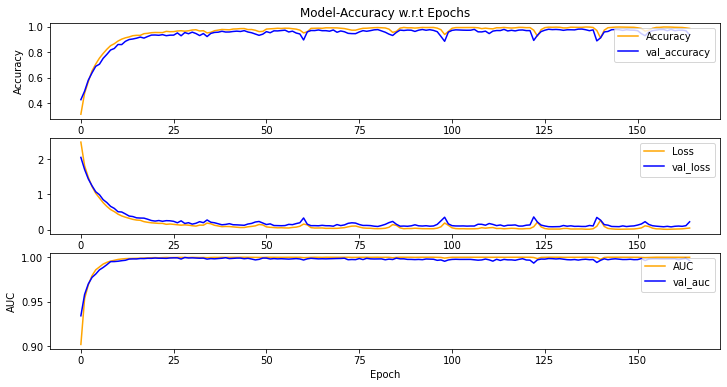

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax3.plot(history.history['auc'], color='orange', label='AUC')
ax3.plot(history.history['val_auc'], color='blue', label='val_auc')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("AUC")
ax3.legend(loc='upper right')
plt.savefig('model_acc_LSTM_ESC50.png')

In [17]:
y_pred = model.predict(np.array(X_test).reshape(3200, 1,20))

In [18]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [19]:
y_pred_classes

array([36, 39, 40, ...,  2, 23, 48])

In [20]:
y_true = np.argmax(np.array(y_test), axis=1)

In [21]:
y_true

array([36, 39, 40, ...,  2, 23, 41])

In [22]:
np.mean(y_pred_classes == y_true)

0.981875

<Figure size 432x288 with 0 Axes>

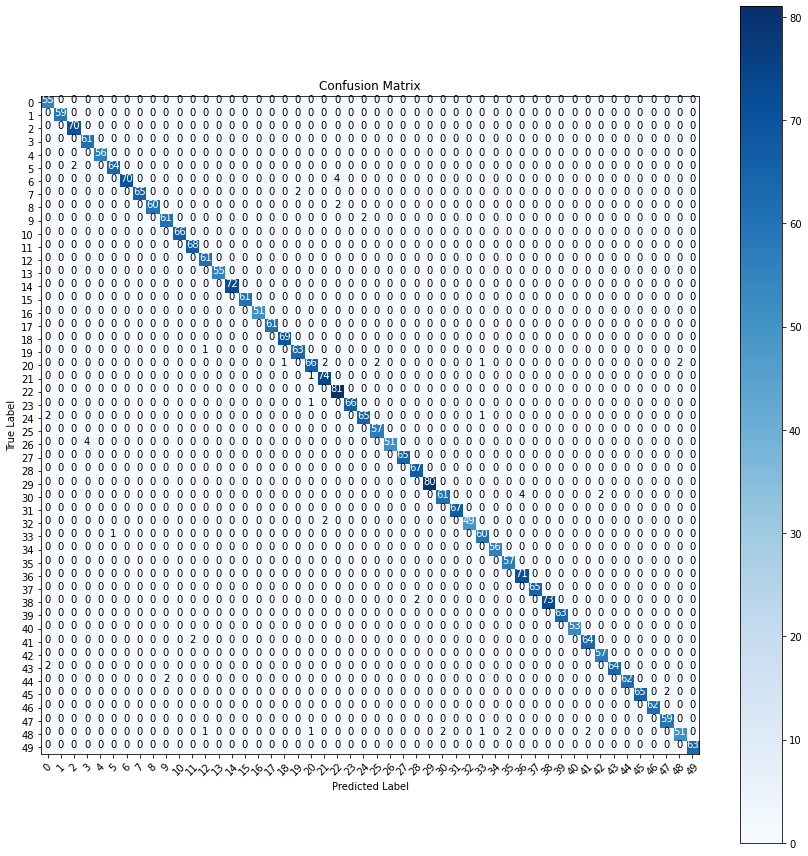

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_classes, y_true,)
import itertools
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(50)))
plt.xticks(tick_marks, range(50), rotation=45)
plt.yticks(tick_marks, range(50))
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('con_matrix_LSTM_ESC50.png')